# Notebook de Estudo do BERT como Encoder

Do enunciado do EP:

> Neste exercício, vamos sugerir a utilizaçãoo de um método auto-regressivo
para a geração de texto. Esta sugestão não é obrigatória, você poderá usar
qualquer outro método que quiser para adaptar o BERT para esta tarefa de
geração de texto, ou at´e mesmo propor uma alteração deste método.

In [1]:
import sys
sys.path.append('..')

In [2]:
from code_utils.metrics import decode_text, generate_sequences, report_linguistic_metrics
from code_utils.models.bilstm.training import define_tokenization_layers, define_full_model
from code_utils.models.bilstm.inference import encoder_inference_model, decoder_inference_model
from code_utils.preprocessing.data_preprocessing import process_data

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abarbosa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertModel
from tensorflow.keras.layers import Attention, Bidirectional, Concatenate, Dense, Embedding, Input, LSTM, GRU
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import pandas as pd

In [4]:
DATA_PATH = "../data/b2w-10k.csv"
REVIEW_TITLE = "review_title"
REVIEW_TEXT = "review_text"
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
(
    encoder_train,
    encoder_test,
    decoder_train,
    decoder_test,
    decoder_label_train,
    decoder_label_test,
) = process_data(DATA_PATH, REVIEW_TEXT, REVIEW_TITLE)

In [6]:
enc_sequence = [len(txt[0].split()) for txt in encoder_train]
np.quantile(enc_sequence, q=[i/10 for i in range(1, 10)]+[.99])

array([  9.,  10.,  12.,  13.,  15.,  18.,  23.,  30.,  45., 117.])

In [7]:
dec_sequence = [len(txt[0].split()) for txt in decoder_train]
np.quantile(dec_sequence, q=[i/10 for i in range(1, 10)]+[.99])

array([ 3.  ,  3.  ,  4.  ,  4.  ,  4.  ,  5.  ,  5.  ,  6.  ,  8.  ,
       14.02])

In [8]:
ENCODER_SEQ_LENGTH = 117
DECODER_SEQ_LENGTH = 8

In [9]:
BERT_MODEL = 'bert-base-multilingual-uncased'
bert_tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL, strip_accents=True)

In [10]:
(
    tokenizer_layer_encoder,
    tokenizer_layer_decoder,
    tokenizer_layer_decoder_inference,
) = define_tokenization_layers(
    encoder_train, decoder_train, ENCODER_SEQ_LENGTH, DECODER_SEQ_LENGTH
)

In [11]:
VOCAB_SIZE_encoder = len(tokenizer_layer_encoder.get_vocabulary()) + 2
VOCAB_SIZE_decoder = len(tokenizer_layer_decoder.get_vocabulary()) + 2
BATCH_SIZE = 128
EPOCHS=10
EMBED_DIM = 256  # tamanho do Embedding de cada token

In [12]:
# Encoder definition
encoder_model = TFBertModel.from_pretrained(
    BERT_MODEL, output_hidden_states=False, output_attentions=False
)

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [13]:
#Encoder part
BERT_DIM = 768
encoder_input = Input(shape=(None,), dtype=tf.int32, name="input_text")
maxpool = tf.keras.layers.GlobalAveragePooling1D(name='average_sequence_return')
last_hidden_state, pooler_output = encoder_model(encoder_input)

In [14]:
#Decoder part
input_text_decoder = Input(shape=(None,),dtype=tf.string, name="decoder_input")
emb_dec_layer = Embedding(VOCAB_SIZE_decoder, EMBED_DIM,name="decoder_embedding")
decoder_lstm = GRU(BERT_DIM, return_sequences=True, return_state=True, name="decoder_rnn")
attention_layer = Attention(name="attention", causal=True)
decoder_dense =  Dense(VOCAB_SIZE_decoder, activation='softmax', name="dense_layer")

In [15]:
# Preprocessing decoder
tokenized_decoder = tokenizer_layer_decoder(input_text_decoder)
dec_emb = emb_dec_layer(tokenized_decoder)

Segundo a documentação:
> This output is usually not a good summary of the semantic content of the input, you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence.

In [16]:
#Decoder definition 
encoder_output = pooler_output
decoder_output, decoder_h_state = decoder_lstm(dec_emb, initial_state=[encoder_output])
attn_context_vector = attention_layer([decoder_output, encoder_output])
decoder_concat_input = Concatenate(name="concat_layer")(
    [decoder_output, attn_context_vector]
)
dense_outputs = decoder_dense(decoder_concat_input)

In [17]:
model = Model(
        [encoder_input, input_text_decoder],
        [dense_outputs],
    )

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_vectorizer (TextVectori (None, 8)            0           decoder_input[0][0]              
__________________________________________________________________________________________________
input_text (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 8, 256)       792320      decoder_vectorizer[0][0]         
______________________________________________________________________________________________

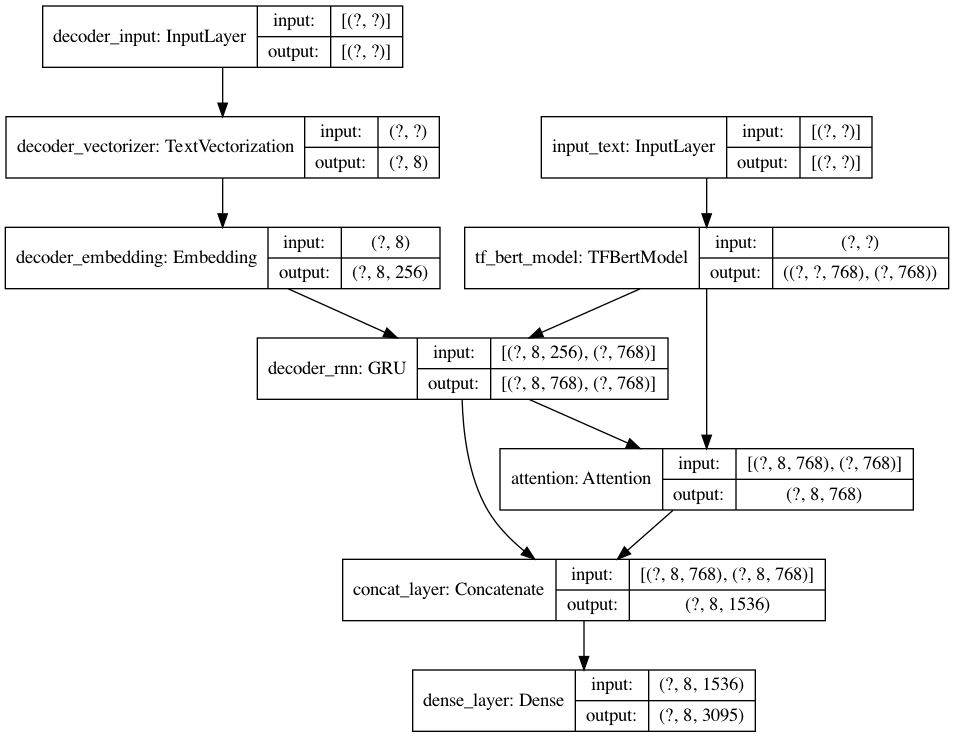

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [20]:
# decay by 1/2 after 4 epochs; 1/3 by epoch 8 and so on
steps_per_epoch = len(encoder_train) // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=steps_per_epoch * 4, decay_rate=1, staircase=False
)
opt = tf.keras.optimizers.Adam(lr_schedule)
model.compile(
    opt,
    loss={"dense_layer": "sparse_categorical_crossentropy"},
    metrics={"dense_layer": "accuracy"},
)

In [21]:
def tokenize_encoder(input_encoder):
    flat_list_encoder = [item for sublist in input_encoder.tolist() for item in sublist]
    tokenized_bert = bert_tokenizer(
        text=flat_list_encoder,
        return_tensors="tf",
        padding=True,
        truncation=True,
    )
    return tokenized_bert

In [23]:
tokenized_train_bert = tokenize_encoder(encoder_train)

In [ ]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

history = model.fit(
    [tokenized_train_bert["input_ids"], decoder_train],
    tokenizer_layer_decoder(decoder_label_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=my_callbacks,
    validation_split=0.1
)

Epoch 1/10


In [ ]:
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

In [ ]:
  _, test_loss, test_acc = model.evaluate([encoder_test, decoder_test],
                                          tokenizer_layer_decoder(decoder_label_test),
                                          batch_size=128)

In [ ]:
tokenized_decoder_inference = tokenizer_layer_decoder_inference(input_text_decoder)
dec_emb_embedding_inference = emb_dec_layer(tokenized_decoder_inference)

In [ ]:
encoder_inference = encoder_inference_model(input_text_encoder, encoder_lstm, enc_emb)

In [ ]:
decoder_inference = decoder_inference_model(
    decoder_embedding=dec_emb_embedding_inference,
    target_text=input_text_decoder,
    latent_dim=EMBED_DIM,
    encoder_sequence_length=ENCODER_SEQ_LENGTH,
    decoder_lstm=decoder_lstm,
    attention_layer=attention_layer,
    decoder_dense=decoder_dense,
)

In [ ]:
sentences = generate_sequences(
    encoder_test,
    decoder_label_test,
    1000,
    encoder_inference,
    decoder_inference,
    DECODER_SEQ_LENGTH,
    tokenizer_layer_decoder_inference,
)

In [ ]:
bleu_metric, nist_metric, meteor_metric = report_linguistic_metrics(sentences)

In [ ]:
pd.DataFrame([test_acc, bleu_metric, nist_metric, meteor_metric]).T.rename(columns={0:'accuracy',
                                                                                    1:'bleu score',
                                                                                    2:'nist score',
                                                                                    3:'meteor score'})